# **AutoRegressive Choir of Ibovespa (Meninas AutoRegressoras do [Ibovespa](https://finance.yahoo.com/quote/%5EBVSP/))**

This is a simple trading strategy based on building AR models for each stock and then running the forecast daily to pick the best 10 returns to buy next day. There is no stop loss but in few cases the model won't buy anything **if forecasts are lower than 1.7%**.

The idea is simple, buy at **Open** and sell at **Close**, yes, it is intraday everyday. At least by theory it should always be easy to sell at **Close** price, since recent *function control for stocks sellouts research indicates just that.*

**Trading costs were not considered,** it is more an excercise than anything.

## Comments

Mostly, stocks could be fitted with an ARMA(0,1) considering the trainning sample, or (0,0) considering **biq**. But some showed a bit more of a pattern, even with a seasonal (1,0)15 element. The constraint of fitting the same specification for all stocks is to make life and code a bit easier, as **forecasting tools from statsmodel** for *out-of-sample* are really bad and I calculated it by hand.

It is easy to see that **in-sample** the model goes really well, and it kinda good until **COVID-19**, in reality, one should stop those kind of intraday strategies (specially long-only, I didn't considered shorting anything) altogether in a crisis like this.

Also, I could've refitted the models everyday in a production cycle, maybe that would yield better result? *Reinforcement learning right?*

### TL;DR
**If you are looking for a *TL;DR*, then go to the last section 'Out of sample validation'**


Thank you for reading and taking a look!

## Author

I am *Leonardo Brioschi*, a Ph.D. Student in Accounting/Finance. Please visit **https://leobrioschi.gitlab.io** 

## Data Wrangling

In [10]:
#Importing Libs

import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import arma_order_select_ic,adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import ceil

#Handling MLE convergence warnings
import warnings

warnings.filterwarnings("ignore", module='statsmodels')#category=DeprecationWarning)

# Viz
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tickers_IBOV = ['ABEV3', 'ALPA4', 'AMER3', 'B3SA3', 'BBAS3', 'BBDC3', 'BBDC4',
                'BEEF3', 'BPAN4', 'BRAP4', 'BRFS3', 'BRKM5', 'BRML3', 'CCRO3', 'CIEL3',
                'CMIG4', 'COGN3', 'CPFE3', 'CPLE6', 'CSAN3', 'CSNA3', 'CYRE3',
                'DXCO3', 'ECOR3', 'EGIE3', 'ELET3', 'ELET6', 'EMBR3', 'ENBR3', 'ENEV3',
                'ENGI11', 'EQTL3', 'EZTC3', 'FLRY3', 'GGBR4', 'GOAU4', 'GOLL4', 'HYPE3',
                'ITSA4', 'ITUB4', 'JBSS3', 'JHSF3', 'LCAM3', 'LREN3', 'MGLU3', 'MRFG3',
                'MRVE3', 'MULT3', 'PCAR3', 'PETR3', 'PETR4', 'POSI3', 'PRIO3', 'QUAL3',
                'RADL3', 'RENT3', 'SANB11', 'SBSP3', 'SULA11', 'SUZB3', 'TAEE11', 'TIMS3',
                'TOTS3', 'UGPA3', 'USIM5', 'VALE3', 'VIIA3', 'VIVT3', 'WEGE3', 'YDUQ3']

start_date = '2013-02-16' #VIIA starts trading 2013-02-16 
end_date = '2022-06-15'
''' equal weights from highest to lowest forecast,
means you are buying one of each paper'''
strategy_weights = [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ] 
split = 0.30

us_t_csv = 'USTREASURY-BILLRATES.csv'

In [3]:
# List comprehension (IBOVESPA's stock have a '.SA' suffix in yahoo finance)

tickers_IBOV_yf = [x + '.SA' for x in tickers_IBOV]
tickers_IBOV_yf[0:5]

['ABEV3.SA', 'ALPA4.SA', 'AMER3.SA', 'B3SA3.SA', 'BBAS3.SA']

In [4]:
# Downloading daily Open/Close prices

oc_IBOV = yf.download(tickers_IBOV_yf, start = start_date, end = end_date)[['Open','Close']]

[*********************100%***********************]  70 of 70 completed


In [5]:
# Calculating daily returns

daily = (oc_IBOV['Close']/oc_IBOV['Open']) -1 

In [6]:
# Just checking out!

daily.head()

ABEV3.SA  ALPA4.SA  AMER3.SA  B3SA3.SA  BBAS3.SA  BBDC3.SA  \
Date                                                                     
2013-02-18  0.005052 -0.019551 -0.052217 -0.003623 -0.009053  0.015017   
2013-02-19  0.004918 -0.014695  0.042146 -0.016715  0.015315 -0.012121   
2013-02-20  0.001217  0.001495 -0.009524 -0.025926 -0.011391 -0.021709   
2013-02-21 -0.015649 -0.013453 -0.011843 -0.009181  0.003571 -0.000854   
2013-02-22  0.007501  0.021970  0.011111  0.012279  0.012598  0.004817   

            BBDC4.SA  BEEF3.SA  BPAN4.SA  BRAP4.SA  ...  TAEE11.SA  TIMS3.SA  \
Date                                                ...                        
2013-02-18  0.019592 -0.011128 -0.007587 -0.014175  ...  -0.011197 -0.012270   
2013-02-19 -0.014714 -0.004515  0.019787 -0.001714  ...  -0.008658 -0.003727   
2013-02-20 -0.022677 -0.023467 -0.007463 -0.032135  ...  -0.007843 -0.013665   
2013-02-21 -0.004274  0.010164 -0.004539  0.000000  ...   0.001312 -0.003774   
2013-02-22  0.011915  0.007710  0.001522 -0.033868  ...  -0.004348  0.006098   

            TOTS3.SA  UGPA3.SA  USIM5.SA  VALE3.SA  VIIA3.SA  VIVT3.SA  \
Date                                                                     
2013-02-18 -0.006579 -0.018020 -0.034483 -0.008600  0.000555  0.002317   
2013-02-19  0.018277  0.017508  0.007217 -0.013623  0.000000  0.017903   
2013-02-20  0.007834  0.027523 -0.043434 -0.031881  0.000000  0.016251   
2013-02-21 -0.007529  0.025297 -0.010548  0.019161  0.000000 -0.016693   
2013-02-22 -0.000229  0.010163 -0.022222 -0.027763  0.000000 -0.000232   

            WEGE3.SA  YDUQ3.SA  
Date                            
2013-02-18 -0.017899  0.005448  
2013-02-19  0.003960 -0.012885  
2013-02-20 -0.019654 -0.001473  
2013-02-21  0.010388  0.002957  
2013-02-22  0.003984  0.013055  

[5 rows x 70 columns]

In [7]:
# There are two days with NaN, I will just delete them

na_count = 0
for i in tickers_IBOV_yf:
    na_count = na_count + daily[i][daily[i].isna()].shape[0]

print(f'{na_count/2} NaN for each stock, totaling {na_count}.')

daily.dropna(axis=0, how='all',inplace=True)

70.0 NaN for each stock, totaling 140.


In [8]:
''' Some days are zero, have no movement, might be holidays '''
daily.drop(index=daily[ daily.sum(axis=1) ==0 ].index,inplace=True)
daily.shape

(2307, 70)

In [43]:
# number of columns to plot:
columns_to_plot = 5
# number of lines to plot dynamically calculated:
lines_to_plot = ceil(len(tickers_IBOV_yf) / columns_to_plot)

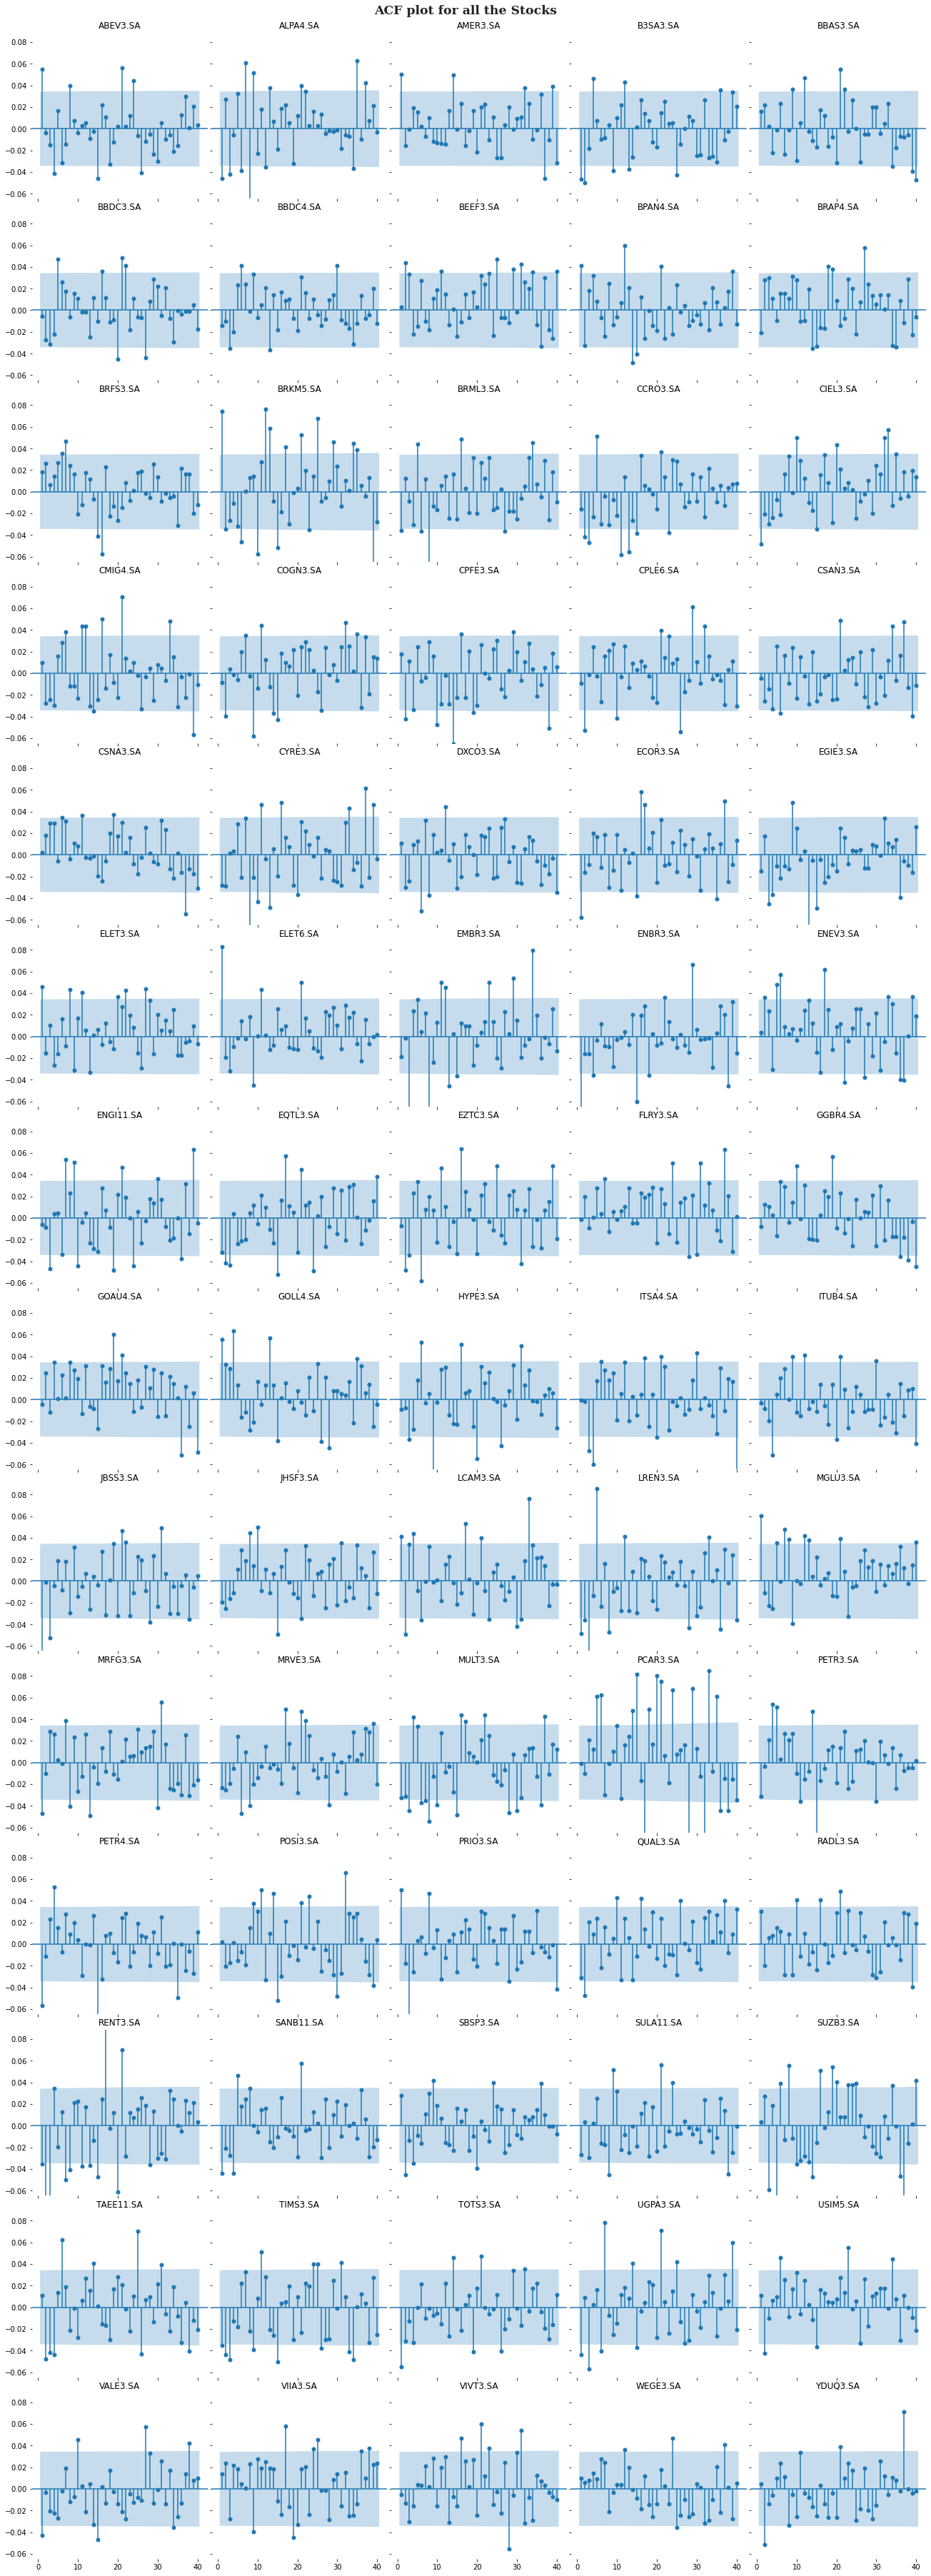

In [44]:
# Lets check the ACF and PACF for the stocks

fig, axs = plt.subplots(lines_to_plot, columns_to_plot, figsize=(18, 50),
                        sharey=True,
                        sharex=True,
                        frameon=False,
                        #facecolor='#DDDDDD',
                        alpha=1.0,
                        constrained_layout=True)

for i, ticket in enumerate(tickers_IBOV_yf):
    row, col = divmod(i, columns_to_plot)
    fig = sm.graphics.tsa.plot_acf(daily[ticket],
                                   lags=40,
                                   ax=axs[row,col],
                                   zero=False,
                                   alpha=.10,
                                   auto_ylims=True)
    axs[row,col].set_title(ticket)
    axs[row,col].spines['top'].set_visible(False)
    axs[row,col].spines['right'].set_visible(False)
    axs[row,col].spines['bottom'].set_visible(False)
    axs[row,col].spines['left'].set_visible(False)

plt.suptitle('ACF plot for all the Stocks',
                    fontsize='xx-large',
                    weight='extra bold',
                    fontfamily= 'serif',
                    stretch='expanded',
                    color='#222222')

plt.savefig('acf_plots.png')

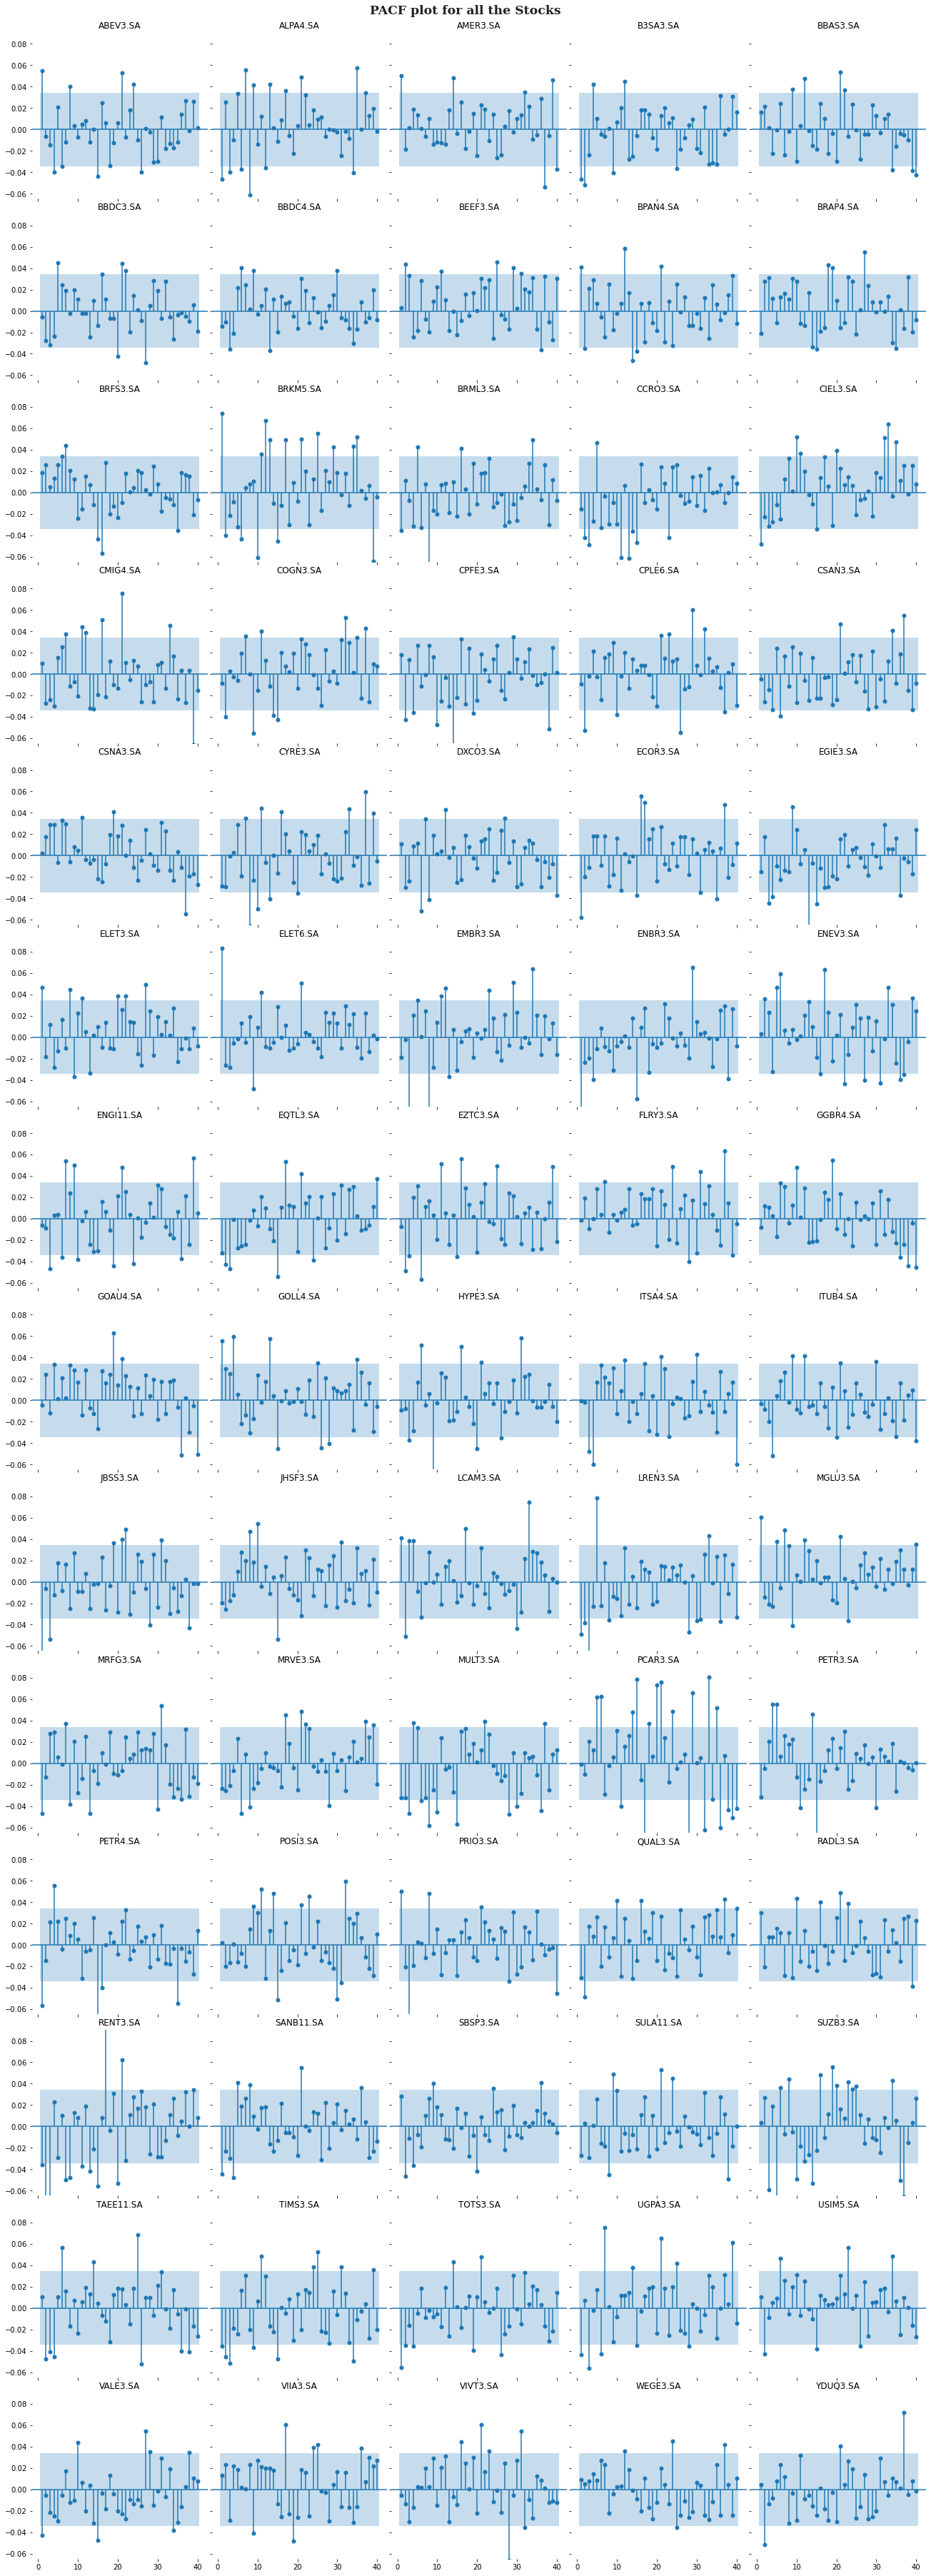

In [45]:
# Lets check the PACF for the stocks

fig, axs = plt.subplots(lines_to_plot, columns_to_plot, figsize=(18, 50),
                        sharey=True,
                        sharex=True,
                        frameon=False,
                        #facecolor='#DDDDDD',
                        alpha=1.0,
                        constrained_layout=True)

for i, ticket in enumerate(tickers_IBOV_yf):
    row, col = divmod(i, columns_to_plot)
    fig = sm.graphics.tsa.plot_pacf(daily[ticket], 
                                    lags=40,
                                    ax=axs[row,col],
                                    zero=False,
                                    alpha=.10,
                                    auto_ylims=True,
                                    method='ywm')
    axs[row,col].set_title(ticket)
    axs[row,col].spines['top'].set_visible(False)
    axs[row,col].spines['right'].set_visible(False)
    axs[row,col].spines['bottom'].set_visible(False)
    axs[row,col].spines['left'].set_visible(False)

plt.suptitle('PACF plot for all the Stocks',
                    fontsize='xx-large',
                    weight='extra bold',
                    fontfamily= 'serif',
                    stretch='expanded',
                    color='#222222')

plt.savefig('pacf_plots.png')

Looking at ACF and PACF graphs, data seem to be fairly random, or it works much more like a degenerated ARIMA model. If this is the case, **BIC** lag selector will yield probably 0 lags (due to being parsimonious) and **AIC** 1-3 in general, since many might also be viewed as an ARMA(1,1) process at least, with maybe some seasonality in 2 weeks? First let's take a look into stationariety.   

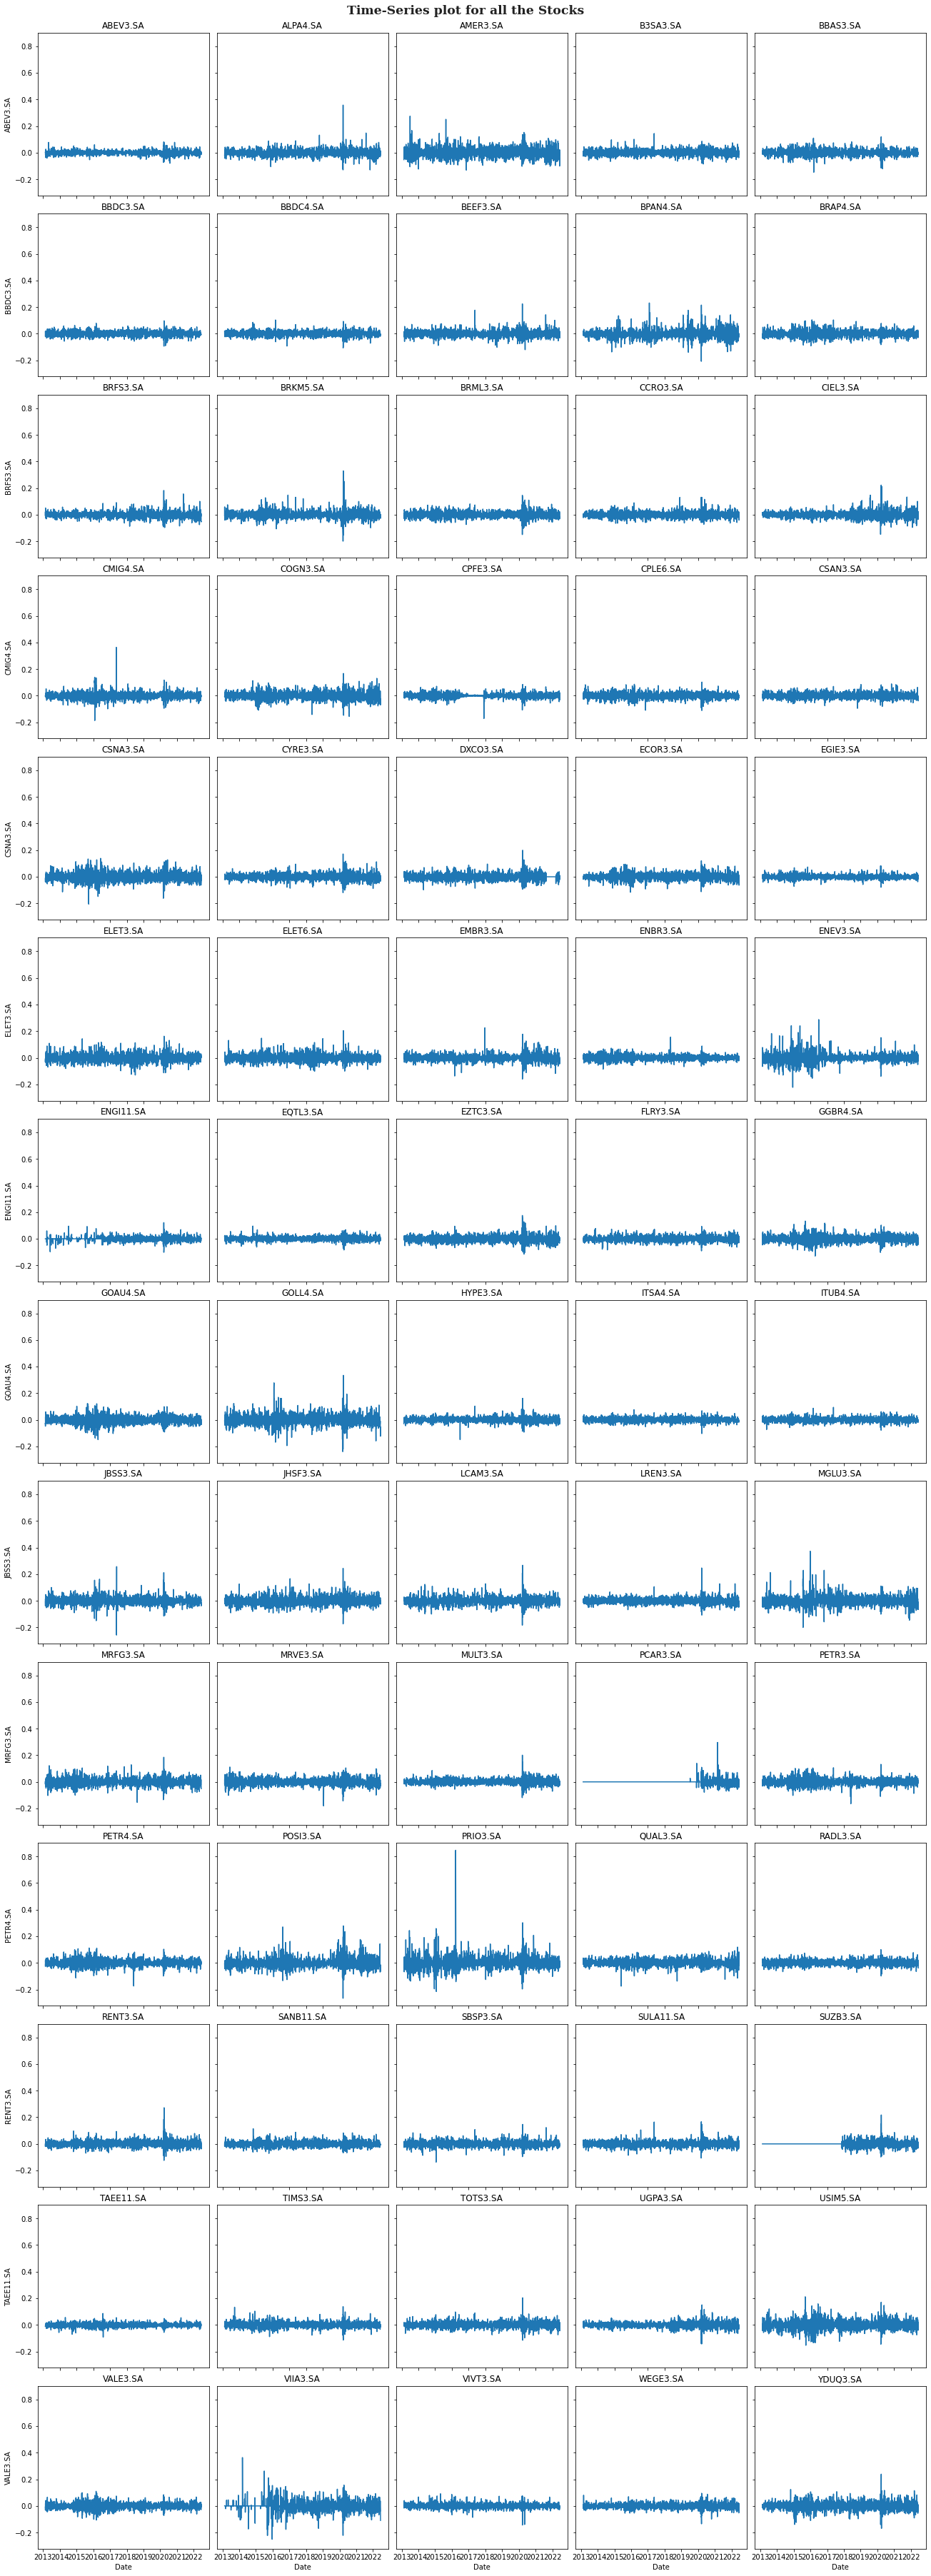

In [46]:
# Lets check the time-series for the stocks daily returns

fig, axs = plt.subplots(lines_to_plot, columns_to_plot, figsize=(18, 50),
                        sharey=True,
                        sharex=True,
                        frameon=False,
                        #facecolor='#DDDDDD',
                        alpha=1.0,
                        constrained_layout=True)

plt.suptitle('Time-Series plot for all the Stocks',
                    fontsize='xx-large',
                    weight='extra bold',
                    fontfamily= 'serif',
                    stretch='expanded',
                    color='#222222')

for i, ticket in enumerate(tickers_IBOV_yf):
    row, col = divmod(i, columns_to_plot)
    sns.lineplot(data=daily[ticket], 
                palette="flare",
                ax=axs[row,col]
                ).set(title=f'{tickers_IBOV_yf[(row)*5+col]}')



plt.savefig('ts_plots.png')

Also, I am interested in the overlay of the graphs, since I intend to use a model specification to every stock. Lets take a look at them. 

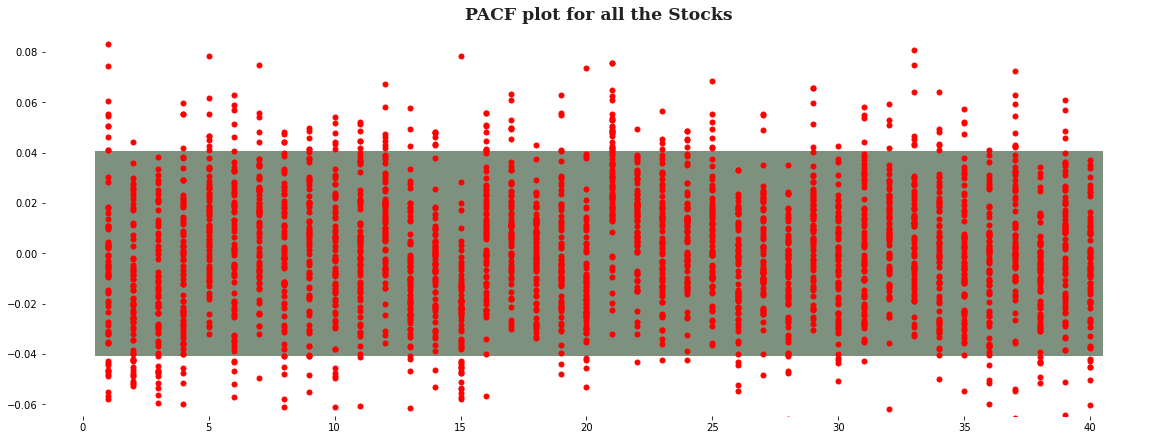

In [47]:
# Lets check the PACF overlay for the stocks

fig, axs = plt.subplots(1, 1, figsize=(16, 6),
                        sharey=True,
                        sharex=True,
                        frameon=False,
                        #facecolor='#DDDDDD',
                        alpha=0.1,
                        constrained_layout=True)

for ticket in tickers_IBOV_yf:
    fig = sm.graphics.tsa.plot_pacf(daily[ticket], 
                                    lags=40,
                                    ax=axs,
                                    zero=False,
                                    alpha=0.05,
                                    auto_ylims=True,
                                    method='ywm',
                                    color='red',
                                    use_vlines=False)
    #axs[1,1].set_title(ticket)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    axs.spines['left'].set_visible(False)

axs.set_title('PACF plot for all the Stocks',
                    fontsize='xx-large',
                    weight='extra bold',
                    fontfamily= 'serif',
                    stretch='expanded',
                    color='#222222');

plt.savefig('PACF_overlay.png')

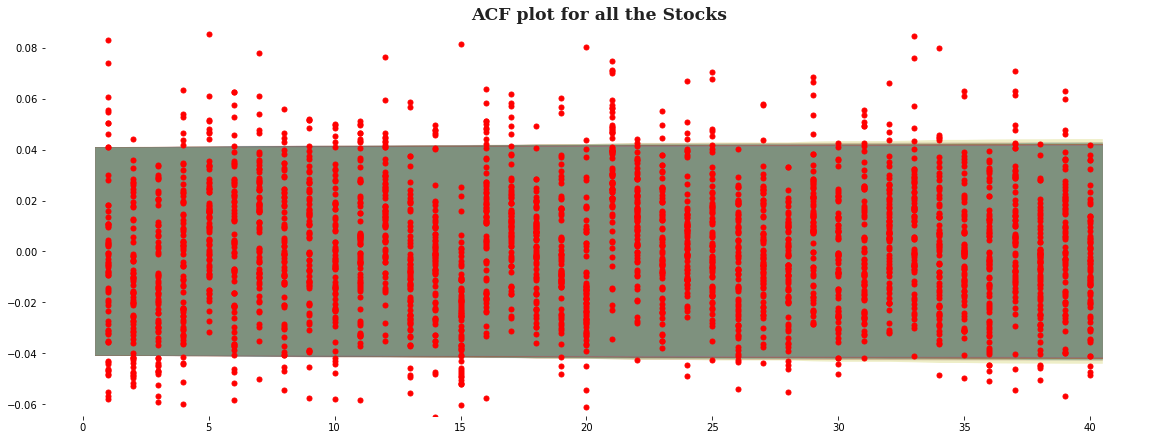

In [48]:
# Lets check the ACF overlay for the stocks

fig, axs = plt.subplots(1, 1, figsize=(16, 6),
                        sharey=True,
                        sharex=True,
                        frameon=False,
                        #facecolor='#DDDDDD',
                        alpha=0.1,
                        constrained_layout=True)


for ticket in tickers_IBOV_yf:
    fig = sm.graphics.tsa.plot_acf(daily[ticket],
                                   lags=40,
                                   ax=axs,
                                   zero=False,
                                   alpha=0.05,
                                   auto_ylims=True,
                                   color='red',
                                   use_vlines=False)
    #axs[1,1].set_title(ticket)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    axs.spines['left'].set_visible(False)

axs.set_title('ACF plot for all the Stocks',
                    fontsize='xx-large',
                    weight='extra bold',
                    fontfamily= 'serif',
                    stretch='expanded',
                    color='#222222');

plt.savefig('ACF_overlay.png')

Considering the Overlay, there is really something going on in general on the 3rd week, 15 days earlier. That would indicate some Seasonality, to our model, and would imply loosing the first 15 entries. on our data. Also, the confidence interval is set at 95% for these graphs (earlier was 90%) 

## Model specification

At least everything seems stationary (from the TS plot earlier). Though strangely some stocks have *quasi-constant* return for many days? In general the Agumented Dickey-Fuller test should confirm the stationariety and reject the unit-root for all the series. But the ADF test technically should be done for each specification, which would be too costly. I will only run the default one.

In [14]:
# Defining an interator that updates a dictionary

adf_dict = dict()
max_adf = 0
for each in tickers_IBOV_yf:
    pvalue = adfuller(daily[each], autolag='AIC', maxlag=30)[0]
    adf_dict[each] = pvalue
    if pvalue > max_adf: max_adf = pvalue


print(f'The highest pvalue is {max_adf}')


The highest pvalue is 0


Ok, so we have stationariety across the board, which is great. Even if the models ends up being not much better than a random walk, if I could hit the sign of each return forecast would be great. Next stage is building the models, but first, now is time to split our data to fit the model, and some *out-of-sample* testing data. I've setup the split size at the beginning of the notebook, so it is easy to change later

In [15]:
''' Checking for lag orders, using AIC '''
ar = [0,0,0,0,0]
ma = [0,0,0]

for stock in tickers_IBOV_yf:
    mod = arma_order_select_ic(daily[stock],ic='aic')
    ar[mod['aic_min_order'][0]] += 1
    ma[mod['aic_min_order'][1]] += 1


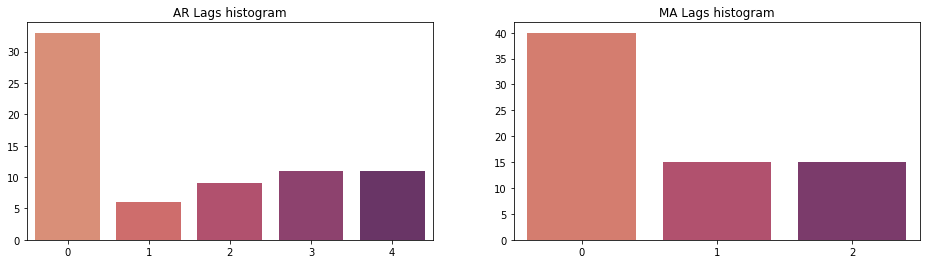

In [16]:
''' (Spongebob's announcer) 32 minutes laterrrr '''
fig, axs = plt.subplots(1, 2, figsize=(16, 4), sharey=False)

sns.barplot(y=ar,x=[0,1,2,3,4], ax=axs[0], palette='flare').set(title='AR Lags histogram');
sns.barplot(y=ma,x=[0,1,2], ax=axs[1], palette='flare').set(title='MA Lags histogram');

plt.savefig('ar_ma_lags.png')

If you add all the AR lags which are greater than **0**, it is possible to see that most stocks has some AR term. The MA on the other hand is much more towards 0 (*summing all the MA > 1 bins is smaller than the 0*). Since the idea is to use one specification to all, it seems feaseble to use **(4,0,0)** as the **ARIMA** order. 

As noted on the **PACF overlay**, it seems there is some seasonal relationship at 15 days (3 working weeks), which could make sense if you are looking at the end of the month. Since the *AR* lags are more predominant i will set the seasonal order to (1,0,0,15).


I will also download **Bovespa's index** to benchmark later.

In [17]:
ibov = yf.download("^BVSP", start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed


In [18]:
ibov.head()

Open     High      Low    Close  Adj Close   Volume
Date                                                              
2013-02-18  57906.0  57929.0  57420.0  57614.0    57614.0  2697200
2013-02-19  57619.0  58061.0  57234.0  57314.0    57314.0  3921000
2013-02-20  57312.0  57569.0  56034.0  56178.0    56178.0  4950200
2013-02-21  56153.0  56227.0  55430.0  56155.0    56155.0  4915800
2013-02-22  56159.0  56742.0  56107.0  56697.0    56697.0  5113800

At this point, I could also try to use **Bovespa's index** as an exgoenous input. But I will leave it for later. Now I am going to build two benchmarks: 
1. Intra-Daily returns for Ibovespa (*Close - Open*);
2. Daily returns for Ibovespa (*Colse(t-1) - Close*).

In [19]:
''' Creating Benchmarks '''
intra_ret_ibov = (ibov['Close']/ibov['Open']) - 1
daily_ret_ibov = ibov[['Close']].pct_change(1)

## Model Fitting

As indicated before, I will fit an (4,0,0)S(1,0,0,15) **SARIMA**

In [20]:
''' Splitting the database '''
test_size = round(len(daily) * (1-split))

fit_df = daily.iloc[0:test_size].copy(deep=True)

In [21]:
''' Fitting each model individually.
Takes about 2 seconds for each model with BFGS'''
models_parm = dict()
models_summ = dict()
arima_order = (4,0,0)
seasonal_order = (1,0,0,15)
params_size = sum(arima_order) + sum(seasonal_order[:3])

for stock in tickers_IBOV_yf:
    mod = SARIMAX(fit_df[stock],
        order=arima_order,
        seasonal_order=seasonal_order,
        simple_differencing=True,
        use_exact_diffuse=True).fit(method='bfgs',
                                maxiter=50,
                                disp=False) #never use basinhopping. although yielded the best results
    models_parm[stock] = mod.params
    models_summ[stock] = mod.summary()

Almost 1.5 minutes to fit all the models! So, instead of forecasting just the training data to do the backtest and later forecast the testing data, I will save some codelines and forecast it all, then I can break the analysis later.

## Forecasting

Forecast will be calculated by hand, as statsmodels predict/forecast methods don't really work well out of fitting data. Then the **Bovespa index: IBOV** will be used as a benchmark, but being traded the same way buying in the *Open* and selling in the *Close*. **Close to Close** returns for the index will also be calculated to use as a comparison.

In [22]:
''' Running a rolling one-step ahead forecast'''
length = len(daily)
forecast_dict = dict()

for stock in tickers_IBOV_yf:
    forecast = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #throwing out the first 15 since we have a seasonal term
    coeffs = np.concatenate([np.reshape(np.array(models_parm[stock][4]),-1),
                        np.zeros(10),
                        np.reshape(np.flip(models_parm[stock][:4].to_numpy()),-1)])
                        
    for i in range(15,length): #losing first 15
        #forecast
        forecast.append((daily[stock].iloc[i-15:i] * coeffs).sum())
    forecast_dict[stock] = forecast

forecast = pd.DataFrame.from_dict(forecast_dict)
forecast.set_index(daily.index , inplace=True)
forecast = forecast.iloc[15:]

In [23]:
''' Finding the highest 10 forecast returns! '''

buy_stocks = forecast.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=10)
buy_stocks.head()

0         1         2         3         4         5  \
Date                                                                     
2013-03-11  JHSF3.SA  CSNA3.SA  AMER3.SA  BRAP4.SA  ENBR3.SA  PRIO3.SA   
2013-03-12  MGLU3.SA  ELET3.SA  CSNA3.SA  PETR3.SA  BRKM5.SA  BPAN4.SA   
2013-03-13  PETR4.SA  PETR3.SA  VALE3.SA  GGBR4.SA  GOLL4.SA  AMER3.SA   
2013-03-14  GOLL4.SA  JHSF3.SA  TIMS3.SA  ALPA4.SA  AMER3.SA  BEEF3.SA   
2013-03-15  JBSS3.SA  MRFG3.SA  GOLL4.SA  VALE3.SA  B3SA3.SA  PETR4.SA   

                   6         7         8         9  
Date                                                
2013-03-11  BRML3.SA  COGN3.SA  VALE3.SA  GGBR4.SA  
2013-03-12  BEEF3.SA  RADL3.SA  GOAU4.SA  EMBR3.SA  
2013-03-13  QUAL3.SA  TOTS3.SA  CSNA3.SA  POSI3.SA  
2013-03-14  B3SA3.SA  BRAP4.SA  QUAL3.SA  CCRO3.SA  
2013-03-15  ITSA4.SA  PRIO3.SA  VIIA3.SA  USIM5.SA

In [24]:
''' Finding the forecasts for the strategy '''

buy_forecasts = forecast.apply(lambda s, n: pd.Series(s.nlargest(n)).dropna().reset_index(drop=True), axis=1, n=10)
buy_forecasts.head()

0         1         2         3         4         5  \
Date                                                                     
2013-03-11  0.002796  0.002501  0.002488  0.002236  0.002102  0.001961   
2013-03-12  0.004024  0.002866  0.002446  0.002156  0.002113  0.002043   
2013-03-13  0.002566  0.002517  0.002503  0.002394  0.002347  0.002281   
2013-03-14  0.003731  0.002951  0.002372  0.002222  0.001912  0.001777   
2013-03-15  0.004840  0.003050  0.002819  0.002122  0.001718  0.001681   

                   6         7         8         9  
Date                                                
2013-03-11  0.001874  0.001698  0.001535  0.001527  
2013-03-12  0.002028  0.001802  0.001793  0.001711  
2013-03-13  0.001641  0.001544  0.001519  0.001500  
2013-03-14  0.001773  0.001663  0.001651  0.001500  
2013-03-15  0.001666  0.001609  0.001439  0.001398

In [25]:
''' Calculating the results for each day.
The *strategy_results* list contains (daily return + 1) ''' 
strategy_results = list()

for day in buy_stocks.index:
    if sum(buy_forecasts.loc[day].to_numpy()) < 0.017: #don't buy if the forecast is less than 1.7%
        result = 1
    else:
        result = sum((daily[buy_stocks.loc[day,:].to_list()].loc[day].to_numpy())* strategy_weights) + 1
    strategy_results.append(result)

In [26]:
''' Calculating accumulated return '''
cum_results = list()

cum_results.append(strategy_results[0])
for i in range(1,len(strategy_results)):
    cum_results.append(strategy_results[i]*cum_results[i-1])

cum_results = np.array(cum_results) - 1
cum_results

array([ 0.00519974, -0.03158355, -0.06352381, ..., -0.99999988,
       -0.99999991, -0.99999991])

In [27]:
'''Making the dataframe with the returns.'''

strategy_returns = pd.DataFrame.from_dict({'daily_plus': strategy_results, 'index':buy_stocks.index})
strategy_returns['daily'] = strategy_returns['daily_plus'].apply(lambda x: x-1)
strategy_returns['cum_ret'] = cum_results
strategy_returns.set_index('index',inplace=True)
strategy_returns.drop(columns=['daily_plus'], inplace=True)

strategy_returns.head()

daily   cum_ret
index                         
2013-03-11  0.005200  0.005200
2013-03-12 -0.036593 -0.031584
2013-03-13 -0.032982 -0.063524
2013-03-14 -0.014990 -0.077562
2013-03-15 -0.003501 -0.080791

In [28]:
''' Need to scale ibov accordingly to the same weights used in the portfolio'''
ibov_return = pd.concat([(daily_ret_ibov * sum(strategy_weights)),(intra_ret_ibov*sum(strategy_weights))],
                        axis=1).iloc[15:]
ibov_return.rename(columns={'Close': 'daily_ibov', 0 : 'intra_ibov'},inplace=True)

#cumulative intraday return
cum_ibov = list()
cum_ibov.append((ibov_return['intra_ibov'][0]) + 1)
for i in range(1,len(ibov_return)):
    cum_ibov.append(((ibov_return['intra_ibov'][i])+1)*cum_ibov[i-1])
cum_ibov = np.array(cum_ibov) - 1

ibov_return['cum_intra'] = cum_ibov

#cumulative close-close return
cum_ibov = list()
cum_ibov.append((ibov_return['daily_ibov'][0]) + 1)
for i in range(1,len(ibov_return)):
    cum_ibov.append(((ibov_return['daily_ibov'][i])+1)*cum_ibov[i-1])
cum_ibov = np.array(cum_ibov) - 1

ibov_return['cum_close'] = cum_ibov

ibov_return.head()

daily_ibov  intra_ibov  cum_intra  cum_close
Date                                                    
2013-03-11    0.019167    0.017967   0.017967   0.019167
2013-03-12   -0.057392   -0.056882  -0.039937  -0.039325
2013-03-13   -0.141387   -0.140540  -0.174865  -0.175152
2013-03-14   -0.018297   -0.018297  -0.189962  -0.190244
2013-03-15   -0.071926   -0.070886  -0.247383  -0.248487

In [29]:
''' Creating the benchmark dataframe'''
benchmark = pd.concat([strategy_returns,ibov_return],axis=1)
benchmark.head()

daily   cum_ret  daily_ibov  intra_ibov  cum_intra  cum_close
2013-03-11  0.005200  0.005200    0.019167    0.017967   0.017967   0.019167
2013-03-12 -0.036593 -0.031584   -0.057392   -0.056882  -0.039937  -0.039325
2013-03-13 -0.032982 -0.063524   -0.141387   -0.140540  -0.174865  -0.175152
2013-03-14 -0.014990 -0.077562   -0.018297   -0.018297  -0.189962  -0.190244
2013-03-15 -0.003501 -0.080791   -0.071926   -0.070886  -0.247383  -0.248487

In [30]:
''' Finding how the strategy fared on the last day '''

#np.set_printoptions(suppress=False)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
benchmark.loc[fit_df.index[-1]]

daily         0.20345
cum_ret      27.05930
daily_ibov    0.09437
intra_ibov    0.09468
cum_intra    -0.99999
cum_close    -0.99998
Name: 2019-08-28 00:00:00, dtype: float64

In [31]:
''' List of days with returns higher than 50%, really, too much! '''
buy_stocks.loc[benchmark[benchmark.daily > 0.50].index]

0         1         2         3         4         5  \
2015-07-31  BRKM5.SA  ELET6.SA  BRAP4.SA  VALE3.SA  CSNA3.SA  GGBR4.SA   
2015-09-10  ECOR3.SA  CSNA3.SA  AMER3.SA  GGBR4.SA  PETR4.SA  CMIG4.SA   
2016-02-01  GOLL4.SA  MGLU3.SA  POSI3.SA  TIMS3.SA  PRIO3.SA  JHSF3.SA   
2017-05-18  JBSS3.SA  PRIO3.SA  ENBR3.SA  VALE3.SA  GGBR4.SA  WEGE3.SA   
2020-03-19  BPAN4.SA  TOTS3.SA  ECOR3.SA  CYRE3.SA  ENBR3.SA  UGPA3.SA   
2020-03-25  TIMS3.SA  AMER3.SA  VIIA3.SA  EZTC3.SA  RENT3.SA  EGIE3.SA   
2020-03-26  PRIO3.SA  GOLL4.SA  ELET6.SA  BPAN4.SA  VIIA3.SA  HYPE3.SA   
2020-04-08  JBSS3.SA  ENBR3.SA  POSI3.SA  B3SA3.SA  DXCO3.SA  JHSF3.SA   
2020-04-22  MGLU3.SA  AMER3.SA  ELET6.SA  JHSF3.SA  PRIO3.SA  EZTC3.SA   
2020-05-14  BRFS3.SA  QUAL3.SA  BRKM5.SA  SBSP3.SA  ELET3.SA  UGPA3.SA   
2020-06-02  BPAN4.SA  CSNA3.SA  GOLL4.SA  DXCO3.SA  GOAU4.SA  EZTC3.SA   
2022-03-18  MGLU3.SA  YDUQ3.SA  ALPA4.SA  GOLL4.SA  COGN3.SA  BRFS3.SA   

                   6         7         8         9  
2015-07-31  MGLU3.SA  BBAS3.SA  HYPE3.SA  USIM5.SA  
2015-09-10  BRKM5.SA  PETR3.SA  EZTC3.SA  CCRO3.SA  
2016-02-01  RADL3.SA  BRML3.SA  PETR4.SA  BRAP4.SA  
2017-05-18  BRAP4.SA  TOTS3.SA  MRFG3.SA  JHSF3.SA  
2020-03-19  PETR4.SA  MRFG3.SA  EZTC3.SA  CSNA3.SA  
2020-03-25  MGLU3.SA  BPAN4.SA  JBSS3.SA  CPLE6.SA  
2020-03-26  POSI3.SA  LCAM3.SA  EMBR3.SA  UGPA3.SA  
2020-04-08  UGPA3.SA  BBDC4.SA  USIM5.SA  EQTL3.SA  
2020-04-22  SUZB3.SA  GOAU4.SA  VIIA3.SA  GGBR4.SA  
2020-05-14  PETR4.SA  CPLE6.SA  YDUQ3.SA  ELET6.SA  
2020-06-02  SUZB3.SA  JHSF3.SA  USIM5.SA  HYPE3.SA  
2022-03-18  ENEV3.SA  PRIO3.SA  JHSF3.SA  VALE3.SA

In [32]:
''' Looking at the values for the first line in the Df above.'''
daily.loc[benchmark[benchmark.daily > 0.50].index[0], buy_stocks[benchmark.daily > 0.50].iloc[0].to_list()]

/tmp/ipykernel_5977/1739998743.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  daily.loc[benchmark[benchmark.daily > 0.50].index[0], buy_stocks[benchmark.daily > 0.50].iloc[0].to_list()]


BRKM5.SA   0.10485
ELET6.SA   0.01064
BRAP4.SA   0.02717
VALE3.SA   0.01940
CSNA3.SA   0.05583
GGBR4.SA   0.01727
MGLU3.SA   0.22945
BBAS3.SA   0.01193
HYPE3.SA   0.00746
USIM5.SA   0.02078
Name: 2015-07-31 00:00:00, dtype: float64

Something happened on **2017-may-18** that the ibov crashed! Oh wait, Scandal in the Brazillian politics:
(*Scandal with the president involving also few companies such as JBS Group*)
https://g1.globo.com/resumo-do-dia/noticia/quinta-feira-18-de-maio-de-2017.ghtml
Amazing that the strategy lived through it. 

In [33]:
''' Something happened on 2017-05-18 that the ibov crashed! 
https://g1.globo.com/economia/mercados/noticia/bovespa-fecha-em-forte-queda-de-olho-em-denuncias-sobre-temer.ghtml'''
benchmark.loc[benchmark[benchmark.daily > 0.50].index]

daily  cum_ret  daily_ibov  intra_ibov  cum_intra  cum_close
2015-07-31 0.50476 -0.72469     0.19400     0.19400   -0.99946   -0.99920
2015-09-10 0.53757 -0.57123    -0.03279    -0.03258   -0.99985   -0.99977
2016-02-01 0.55075 -0.86869     0.04059     0.04282   -0.99999   -0.99998
2017-05-18 0.62611  2.88078    -0.87992    -0.87938   -0.99999   -0.99999
2020-03-19 0.71555 21.72862     0.21481     0.21665   -1.00000   -1.00000
2020-03-25 0.97893  2.65412     0.74962     0.74992   -1.00000   -1.00000
2020-03-26 0.84308  5.73483     0.36742     0.36742   -1.00000   -1.00000
2020-04-08 0.53645 -0.19278     0.29689     0.29999   -1.00000   -1.00000
2020-04-22 0.51785 -0.27520     0.21704     0.21704   -1.00000   -1.00000
2020-05-14 0.52409 -0.92720     0.15931     0.15957   -1.00000   -1.00000
2020-06-02 0.53294 -0.85464     0.27375     0.27352   -1.00000   -1.00000
2022-03-18 0.54841 -1.00000     0.19765     0.19765   -1.00000   -1.00000

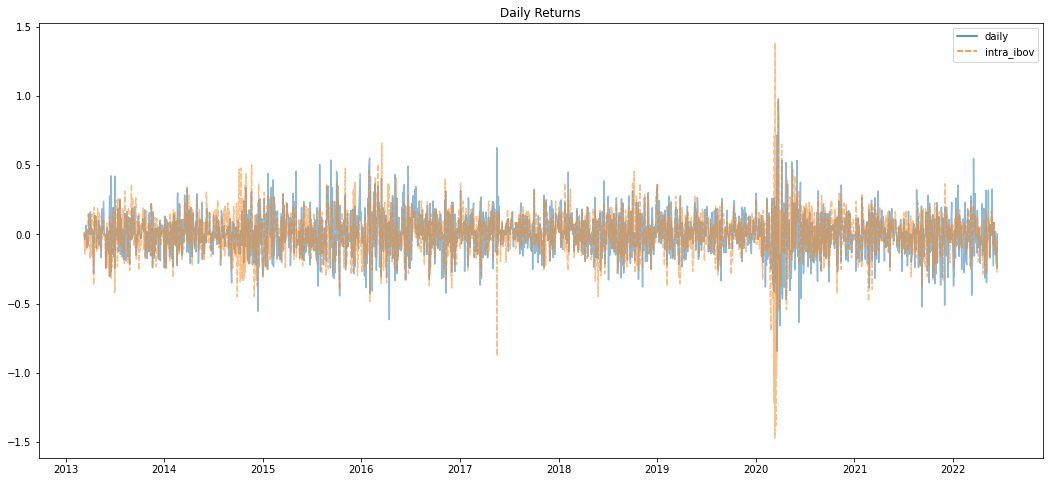

In [34]:
''' Plotting daily return comparison '''
fig, ax = plt.subplots(1,1,figsize=(18,8))
sns.lineplot(data=benchmark[['daily','intra_ibov']], alpha=0.5,ax=ax).set(title='Daily Returns');

plt.savefig('daily_return.png')

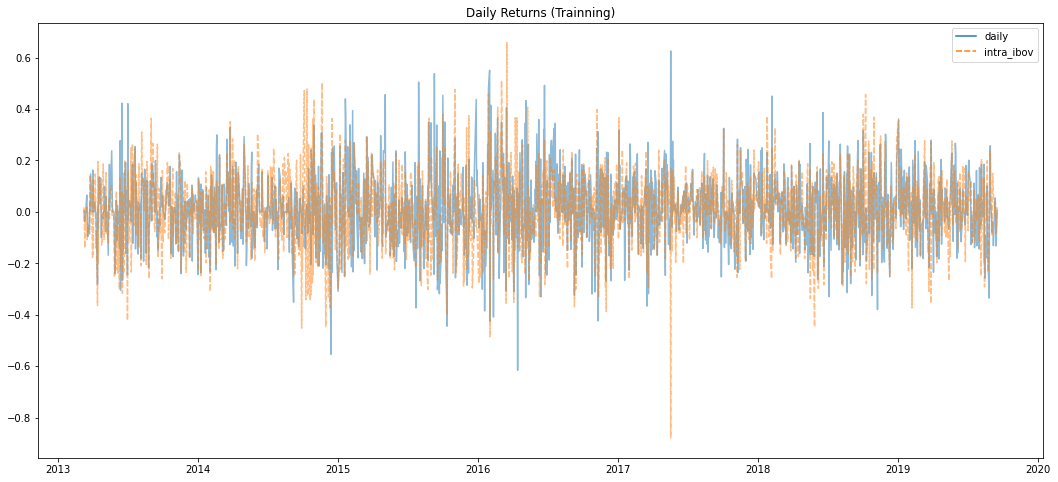

In [35]:
''' Plotting daily return comparison,
    only for the trainning data '''
fig, ax = plt.subplots(1,1,figsize=(18,8))
sns.lineplot(data=benchmark[['daily','intra_ibov']].iloc[:test_size], alpha=0.5,ax=ax).set(title='Daily Returns (Trainning)');

plt.savefig('daily_return_trainning.png')

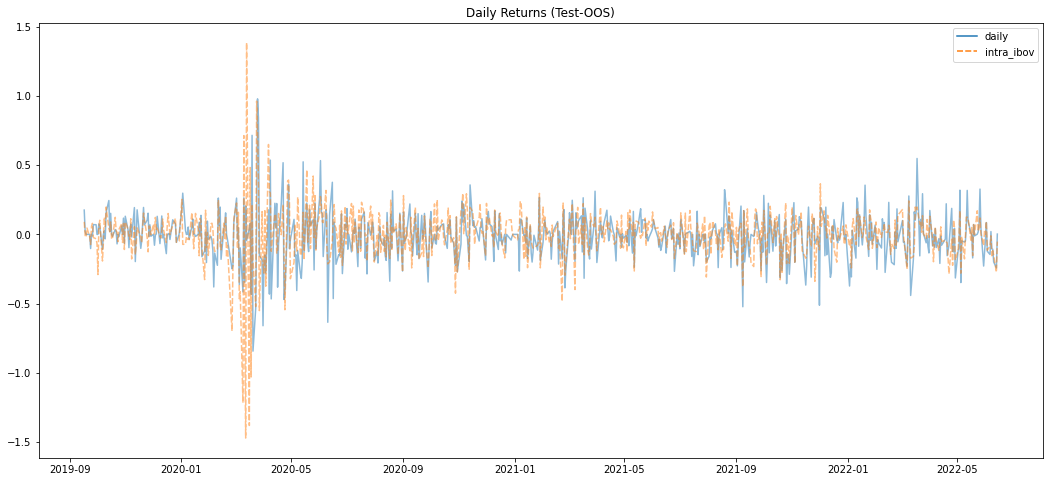

In [36]:
''' Plotting daily return comparison,
    only for the test data (out-of-sample)'''
fig, ax = plt.subplots(1,1,figsize=(18,8))
sns.lineplot(data=benchmark[['daily','intra_ibov']].iloc[test_size:], alpha=0.5,ax=ax).set(title='Daily Returns (Test-OOS)');

plt.savefig('daily_return_test.png')

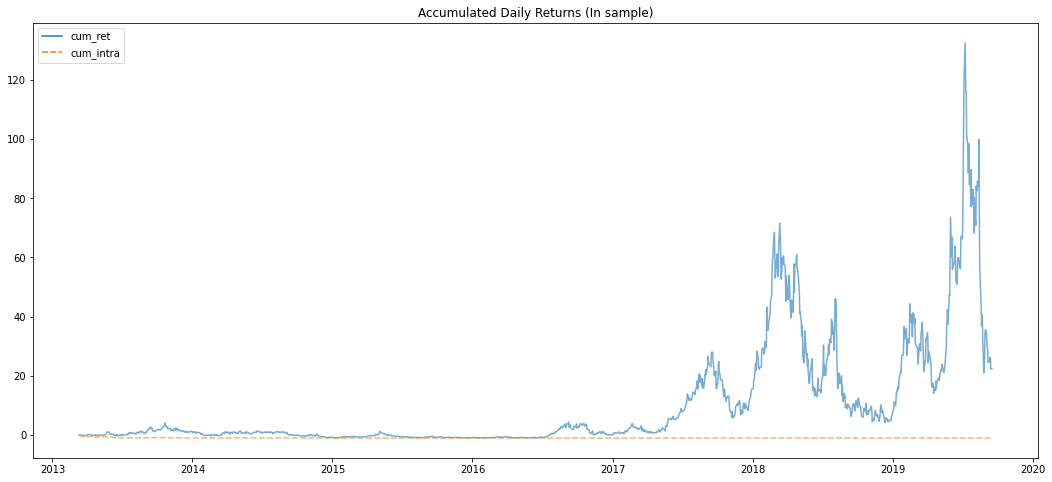

In [37]:
fig, ax = plt.subplots(1,1,figsize=(18,8))
sns.lineplot(data=benchmark[['cum_ret','cum_intra']].iloc[:test_size],alpha=0.6,
                ax=ax).set(title='Accumulated Daily Returns (In sample)');

plt.savefig('cum_daily_returns.png')

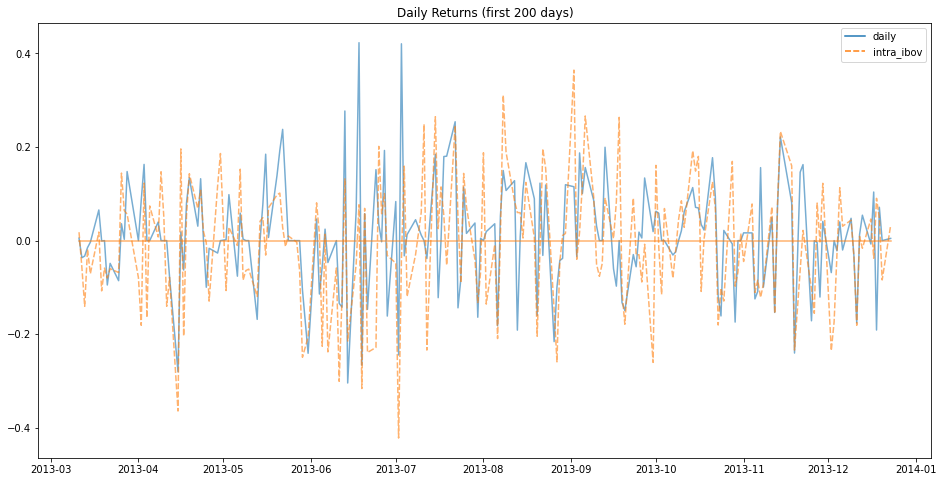

In [38]:

fig, ax = plt.subplots(1,1,figsize=(16,8))
sns.lineplot(data=benchmark[['daily','intra_ibov']].iloc[:200], ax=ax, alpha=0.6);
sns.lineplot(y=np.zeros(200), x=benchmark['intra_ibov'].iloc[:200].index, ax=ax,
                alpha=0.6).set(title='Daily Returns (first 200 days)');

plt.savefig('daily_return_train200.png')

In [39]:
neg_ibov = benchmark[benchmark['intra_ibov'] < 0 ].shape[0]
neg_strat = benchmark[benchmark['daily'] < 0 ].shape[0]

neg_test_ibov = benchmark.iloc[test_size:].loc[benchmark['intra_ibov'] < 0.0 ].shape[0]
neg_test_strat = benchmark.iloc[test_size:].loc[benchmark['daily'] < 0.0 ].shape[0]

print(f'The Ibovespa index has {neg_ibov} negative daily returns for the whole set, and the strategy has {neg_strat}')
print(f'On the Out-of-sample test Ibovespa index has {neg_test_ibov} negative days, and the strategy has {neg_test_strat}')

The Ibovespa index has 1110 negative daily returns for the whole set, and the strategy has 1006
On the Out-of-sample test Ibovespa index has 327 negative days, and the strategy has 325


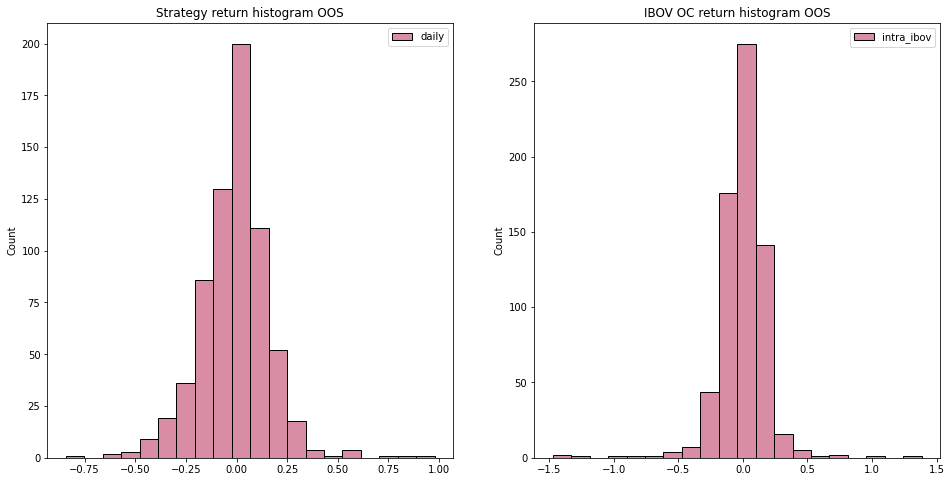

In [40]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.histplot(data=benchmark[['daily']].iloc[test_size:], ax=ax[0],
                alpha=0.6, palette='flare', bins=20).set(title='Strategy return histogram OOS');
sns.histplot(data=benchmark[['intra_ibov']].iloc[test_size:], ax=ax[1],
                alpha=0.6, palette='flare', bins=20).set(title='IBOV OC return histogram OOS');

plt.savefig('daily_vs_ibov_hist.png')

Ok, it makes sense that the **Strategy** is less centered than the **Bovespa's index**, how else could one generate more value? Although the market index surely has bigger tails.

## Out of sample validation

Now I need to test the OOS validation. Surely the 2019-2022 years were not very good for Brazil

In [41]:
''' Creating out of sample only benchmark'''
oos_bench = benchmark.iloc[test_size-1:].copy(deep=True)
oos_bench.iloc[0] = 0

def cummulative_prod(series):
    cummulative = [series[0]+1]
    for i in range(1,len(series)):
        cummulative.append((series[i]+1)*cummulative[i-1])
    cummulative = np.array(cummulative) - 1
    return cummulative

oos_bench['cum_ret'] = cummulative_prod(oos_bench['daily'])
oos_bench['cum_close'] = cummulative_prod(oos_bench['daily_ibov'])
oos_bench['cum_intra'] = cummulative_prod(oos_bench['intra_ibov'])

oos_bench.head()

daily  cum_ret  daily_ibov  intra_ibov  cum_intra  cum_close
2019-09-16 0.00000  0.00000     0.00000     0.00000    0.00000    0.00000
2019-09-17 0.17549  0.17549     0.09037     0.09037    0.09037    0.09037
2019-09-18 0.02266  0.20213    -0.00812    -0.00803    0.08162    0.08152
2019-09-19 0.00000  0.20213    -0.01846    -0.02066    0.05927    0.06155
2019-09-20 0.00000  0.20213     0.04581     0.04581    0.10780    0.11018

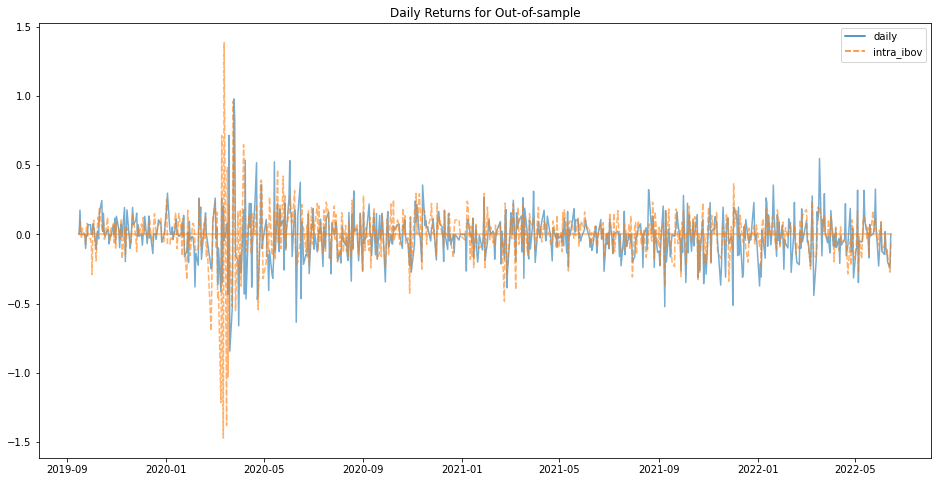

In [42]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
sns.lineplot(data=oos_bench[['daily','intra_ibov']], ax=ax, alpha=0.6);
sns.lineplot(y=np.zeros(len(oos_bench)), x=oos_bench.index, ax=ax,
                alpha=0.6).set(title='Daily Returns for Out-of-sample');

plt.savefig('daily_return_oos.png')

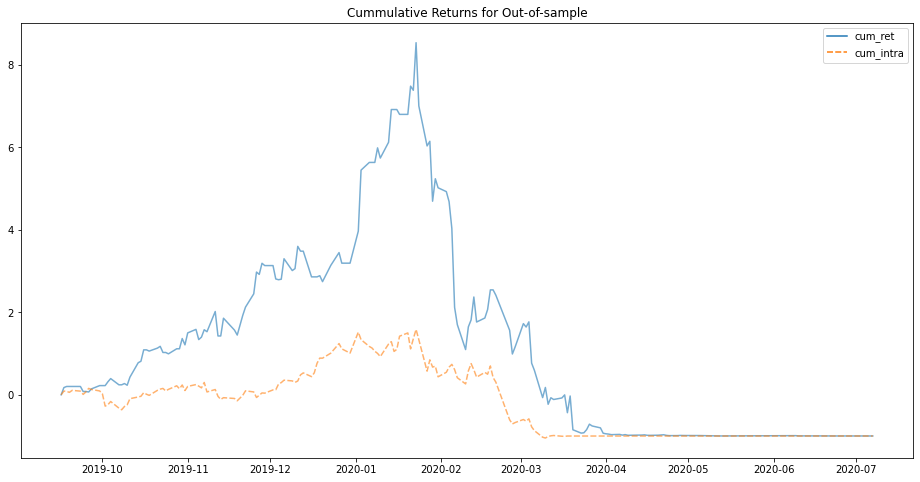

In [43]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
sns.lineplot(data=oos_bench[['cum_ret','cum_intra']].iloc[:200],
                ax=ax, alpha=0.6).set(title='Cummulative Returns for Out-of-sample');
#sns.lineplot(y=np.zeros(len(oos_bench)), x=oos_bench.index, ax=ax,
                #alpha=0.6).set(title='Daily Returns for Out-of-sample');

plt.savefig('cumm_return_oos.png')

At this point, the **COVID-19** pandemic wiped out 100% (nearly) or your money if you kept trading daily. It would surely be wise to put an stop-loss on such times. At least the strategy could hold on a few more weeks, the models can't glide through this scenario. 
- But what would happend if you started it all again after **feb.-2022**, and hit the war?

In [113]:
''' Creating out of sample, after covid breakout benchmark'''
covid_end = '2022-02-25'
oos2_bench = benchmark.loc[covid_end:].copy(deep=True)
oos2_bench.iloc[0] = 0


oos2_bench['cum_ret'] = cummulative_prod(oos2_bench['daily'])
oos2_bench['cum_close'] = cummulative_prod(oos2_bench['daily_ibov'])
oos2_bench['cum_intra'] = cummulative_prod(oos2_bench['intra_ibov'])

oos2_bench.head()

daily  cum_ret  daily_ibov  intra_ibov  cum_intra  cum_close
2022-02-25  0.00000  0.00000     0.00000     0.00000    0.00000    0.00000
2022-03-02  0.10002  0.10002     0.17960     0.17951    0.17951    0.17960
2022-03-03 -0.05637  0.03801    -0.00069    -0.00061    0.17879    0.17878
2022-03-04 -0.05260 -0.01659    -0.06009    -0.06009    0.10796    0.10795
2022-03-07 -0.22997 -0.24274    -0.25167    -0.25125   -0.17041   -0.17089

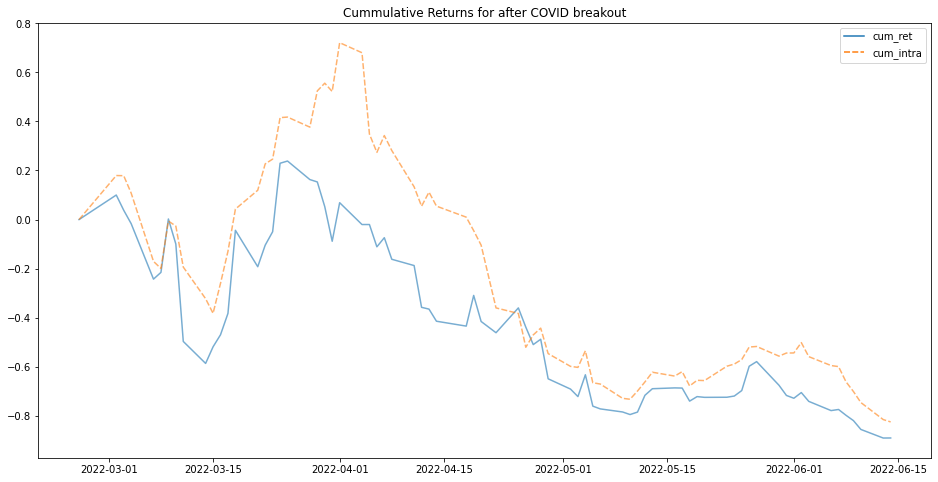

In [96]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
sns.lineplot(data=oos2_bench[['cum_ret','cum_intra']].iloc[:200],
                ax=ax, alpha=0.6).set(title='Cummulative Returns for after COVID breakout');
#sns.lineplot(y=np.zeros(len(oos_bench)), x=oos_bench.index, ax=ax,
                #alpha=0.6).set(title='Daily Returns for Out-of-sample');

plt.savefig('cumm_return_oos2.png')

Sadly, when Russian-Ukraine war started again, everything went to shambles again, but the strategy seems a bit worse than the market, probably because the models should be refitted.

In [108]:
tbill = pd.read_csv(us_t_csv, engine='pyarrow')
tbill['Date'] = pd.to_datetime(tbill['Date'])
tbill.set_index(tbill['Date'],inplace=True)
tbill = tbill[['13 Wk Coupon Equiv']].copy(deep=True)
tbill.rename(columns={'13 Wk Coupon Equiv':'tbill'},inplace=True)

In [122]:
sharpe_df = oos_bench.merge(tbill, how='left',left_index=True, right_index=True)
sharpe_df.dropna(axis=0,how='any',inplace=True)
sharpe_df.drop(columns=['cum_ret','cum_intra','cum_close'],inplace=True)
sharpe_df['tbill'] = sharpe_df['tbill'].apply(lambda x: float((1+(x/100))**(1/365))-1) #daily tbill
for each in ['daily','daily_ibov','intra_ibov']:
    sharpe_df[each] = sharpe_df[each] - sharpe_df['tbill'] 
sharpe_df.head()

daily  daily_ibov  intra_ibov   tbill
2019-09-16 -0.00005    -0.00005    -0.00005 0.00005
2019-09-17  0.17544     0.09032     0.09032 0.00005
2019-09-18  0.02261    -0.00818    -0.00808 0.00005
2019-09-19 -0.00005    -0.01852    -0.02071 0.00005
2019-09-20 -0.00005     0.04576     0.04576 0.00005

In [123]:
sharp_ratio = dict()

for each in ['daily','daily_ibov','intra_ibov']:
    sharp_ratio[each]  = (np.prod(sharpe_df[each].to_numpy() +1) -1) / sharpe_df[each].std()
    print(f'{each} sharp ratio is: {sharp_ratio[each]}')

daily sharp ratio is: -5.665834729004218
daily_ibov sharp ratio is: -4.845437905827047
intra_ibov sharp ratio is: -4.866797219728131


Of course, the sharp ratio of the period from 2019 until today is bad for both, but our strategy seems much riskier. What would happen if we calculated the sharp ratio until the end of january?

In [125]:
sharp_ratio = dict()

for each in ['daily','daily_ibov','intra_ibov']:
    sharp_ratio[each]  = (np.prod(sharpe_df[each].loc[:'2020-02-01'].to_numpy() +1) -1) / sharpe_df[each].std()
    print(f'{each} sharp ratio is: {sharp_ratio[each]}')

daily sharp ratio is: 15.730880006269029
daily_ibov sharp ratio is: 1.7777384943253276
intra_ibov sharp ratio is: 0.9356305336700748


Okey, so we have a good sharp ratio, which is great. Also, it seems that just holding the index is a better investment than doing the Open-Close trading strategy that I am proposing to my portfolio!

A lot more could be done to test the strategy's relevance! First, thanks to *Ph.D Tiago Alves (UAH)* to pointing out that
1. in fact, the whole fitting period could be a "bubble" and mostly any strategy which focused on few more profitable stocks would just skyrocket, which makes sense since a lot of return comes from **MGLU3**.
Also, 
2. Survivorship BIAS is creeping around, but I couldn't find any easy way to gather all the stocks on **Bovespa's index** for each day (*They only provide the latest*), and If I would test the strategy for different companies, that would mean **refitting the model in different time-periods.**

Since it is just an excercise, those are things to think in a production level model.